### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Sep 30 15:52:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [5]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.1 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 36.5/112.6 GB disk)


**NOTE:** When training YOLO11, make sure your data is located in `{HOME}/datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. When downloading data from [Roboflow Universe](https://universe.roboflow.com/), use the YOLOv8 format.

In [4]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="UynPSQgEXONS23dKJYtP")
project = rf.workspace("roboflow-jvuqo").project("poker-cards-fmjio")
version = project.version(4)
dataset = version.download("yolov8")


/content/datasets
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.3.1, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to poker-cards-4 in yolov8:: 100%|██████████| 1810/1810 [00:00<00:00, 3236.18it/s]


**NOTE:** Make sure to run commands below to make dataset work with YOLO11 training.

In [6]:
!sed -i '$d' {dataset.location}/data.yaml   # Delete the last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the second-to-last line
!sed -i '$d' {dataset.location}/data.yaml   # Delete the third-to-last line

!echo 'test: ../test/images' >> {dataset.location}/data.yaml
!echo 'train: ../train/images' >> {dataset.location}/data.yaml
!echo 'val: ../valid/images' >> {dataset.location}/data.yaml

## Custom Training

In [7]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

/content
100% 18.4M/18.4M [00:00<00:00, 147MB/s] 
WARNING ⚠️ yolo11s.pt appears to require 'dill', which is not in Ultralytics requirements.
AutoInstall will run now for 'dill' but this feature will be removed in the future.
Recommend fixes are to train a new model using the latest 'ultralytics' package or to run a command with an official Ultralytics model, i.e. 'yolo predict model=yolov8n.pt'
requirements: Ultralytics requirement ['dill'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.0 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 2.4s, installed 1 package: ['dill']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

Ultralytics 8.3.1 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/poker-cards-4/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, devi

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [8]:
!ls {HOME}/runs/detect/train/

args.yaml					    P_curve.png       train_batch2.jpg
confusion_matrix_normalized.png			    PR_curve.png      val_batch0_labels.jpg
confusion_matrix.png				    R_curve.png       val_batch0_pred.jpg
events.out.tfevents.1727711689.ce614af87db0.2311.0  results.csv       val_batch1_labels.jpg
F1_curve.png					    results.png       val_batch1_pred.jpg
labels_correlogram.jpg				    train_batch0.jpg  weights
labels.jpg					    train_batch1.jpg


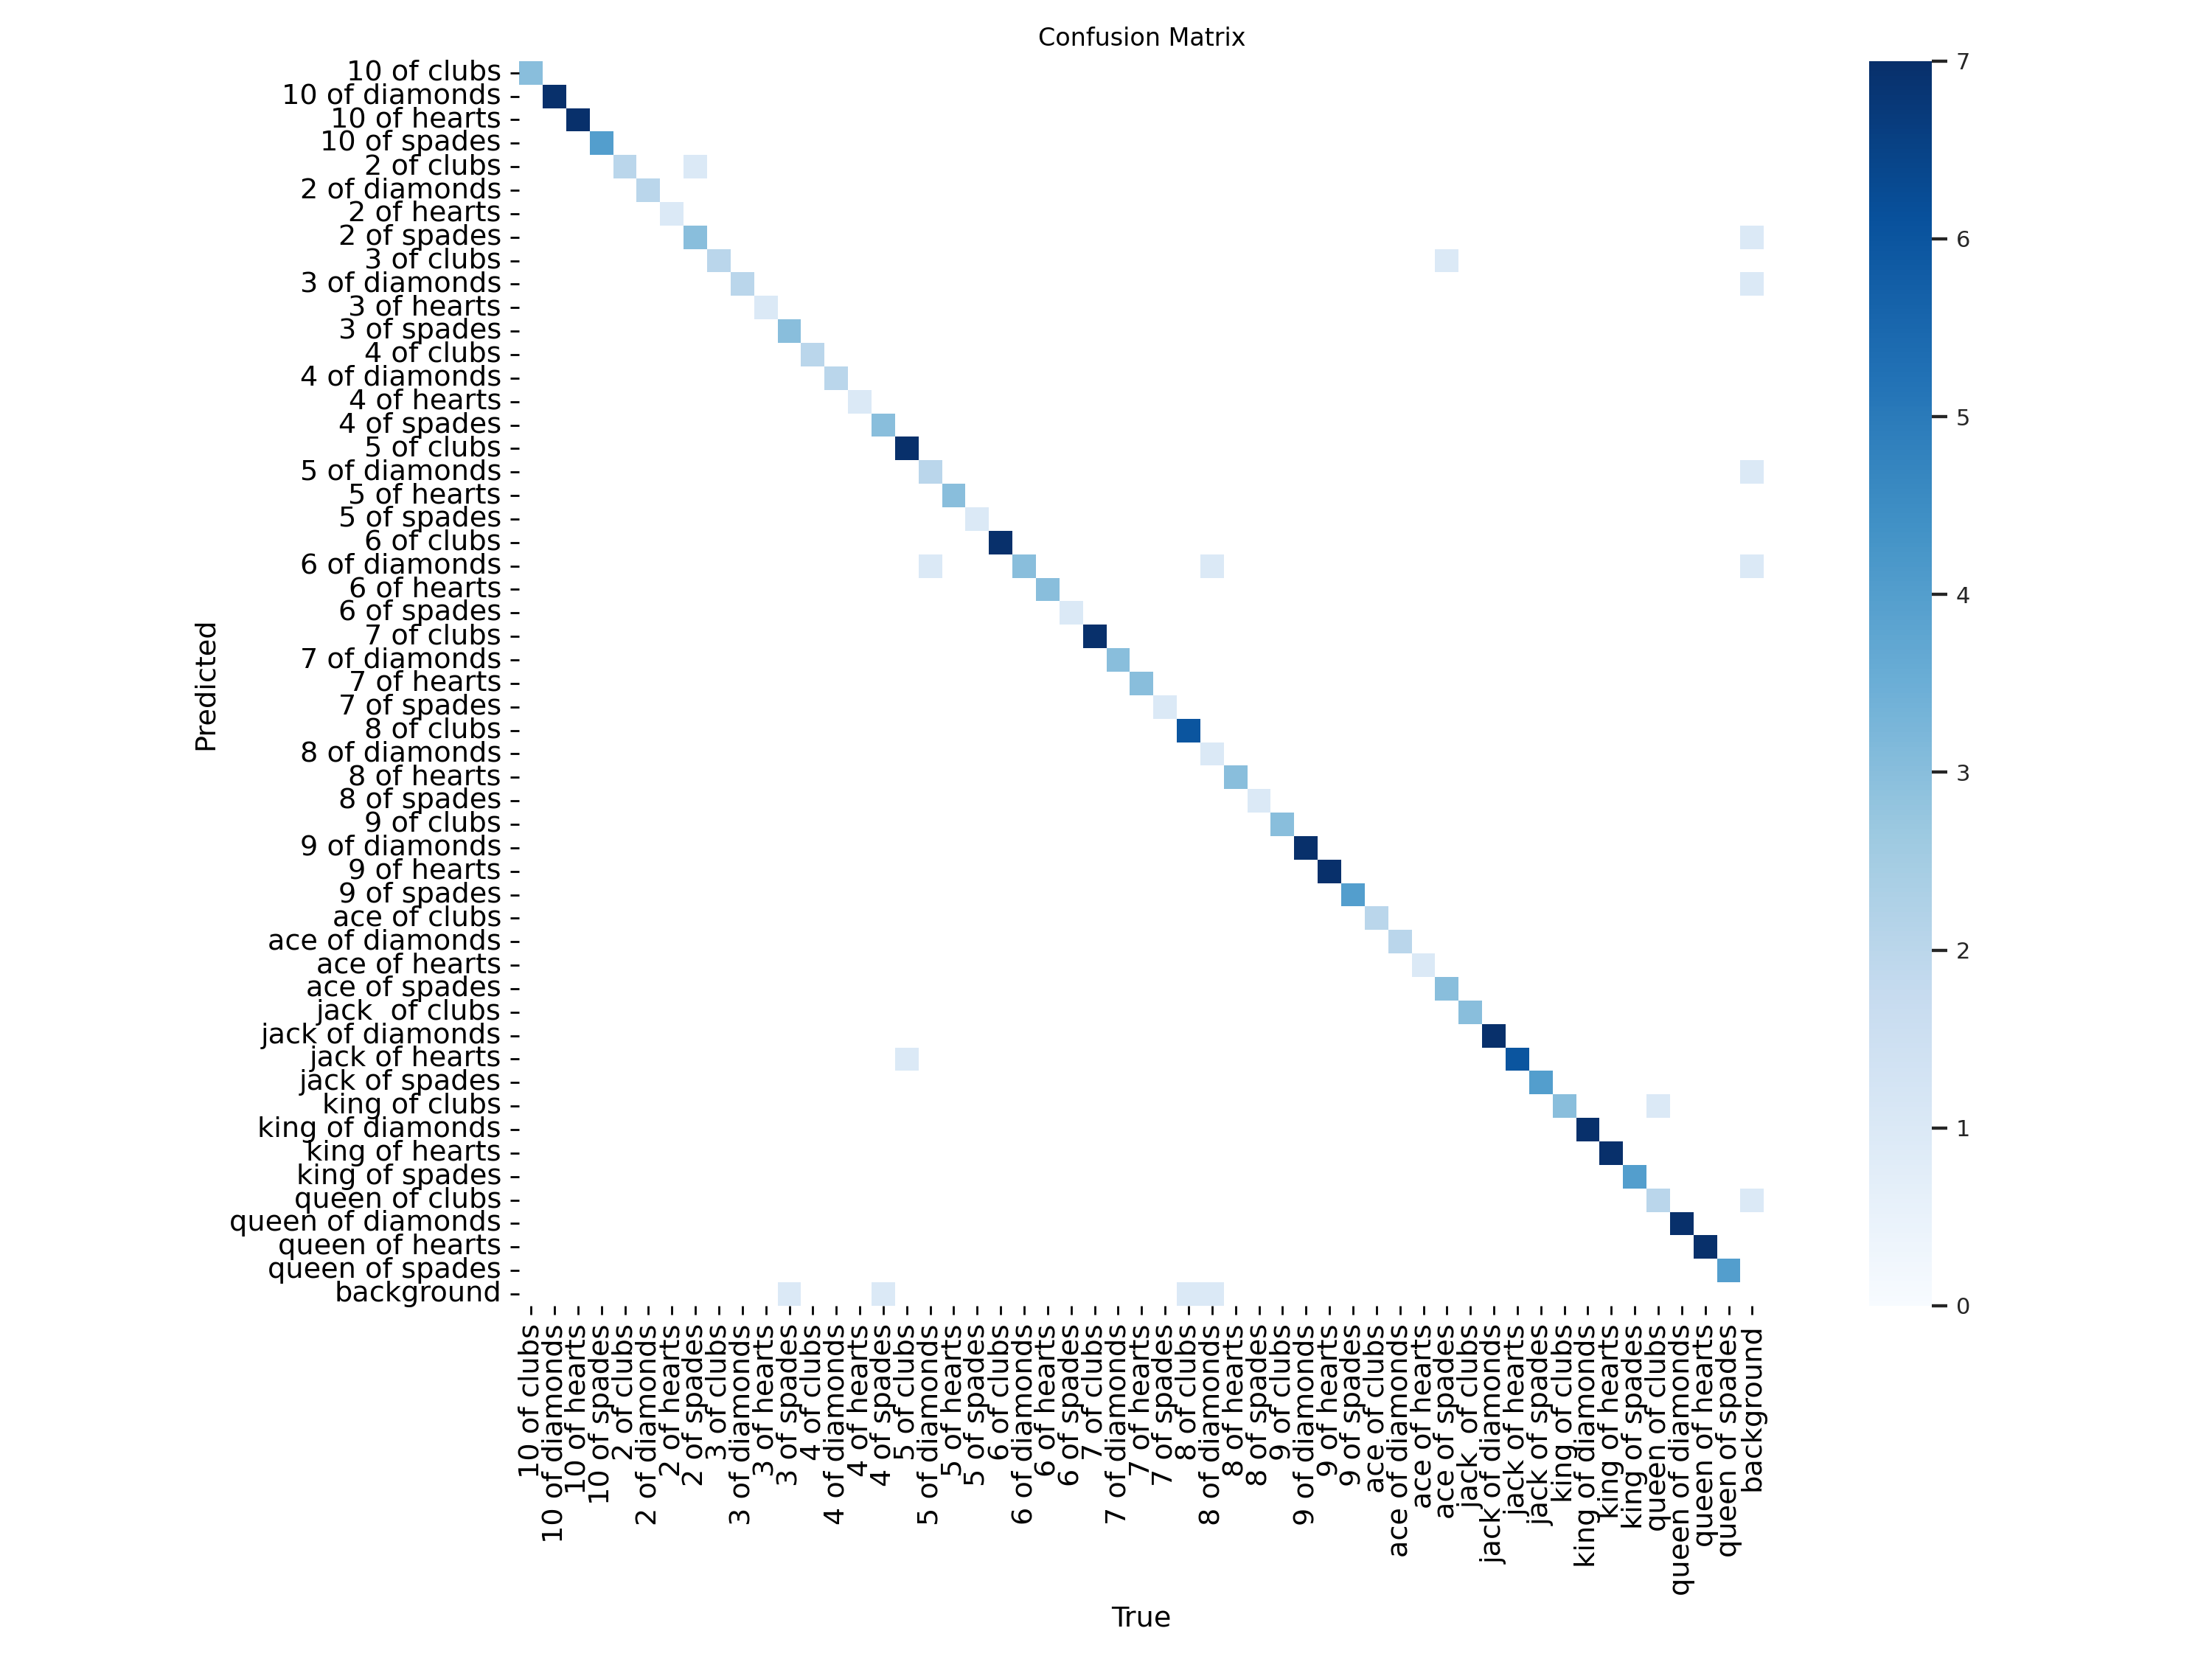

In [9]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

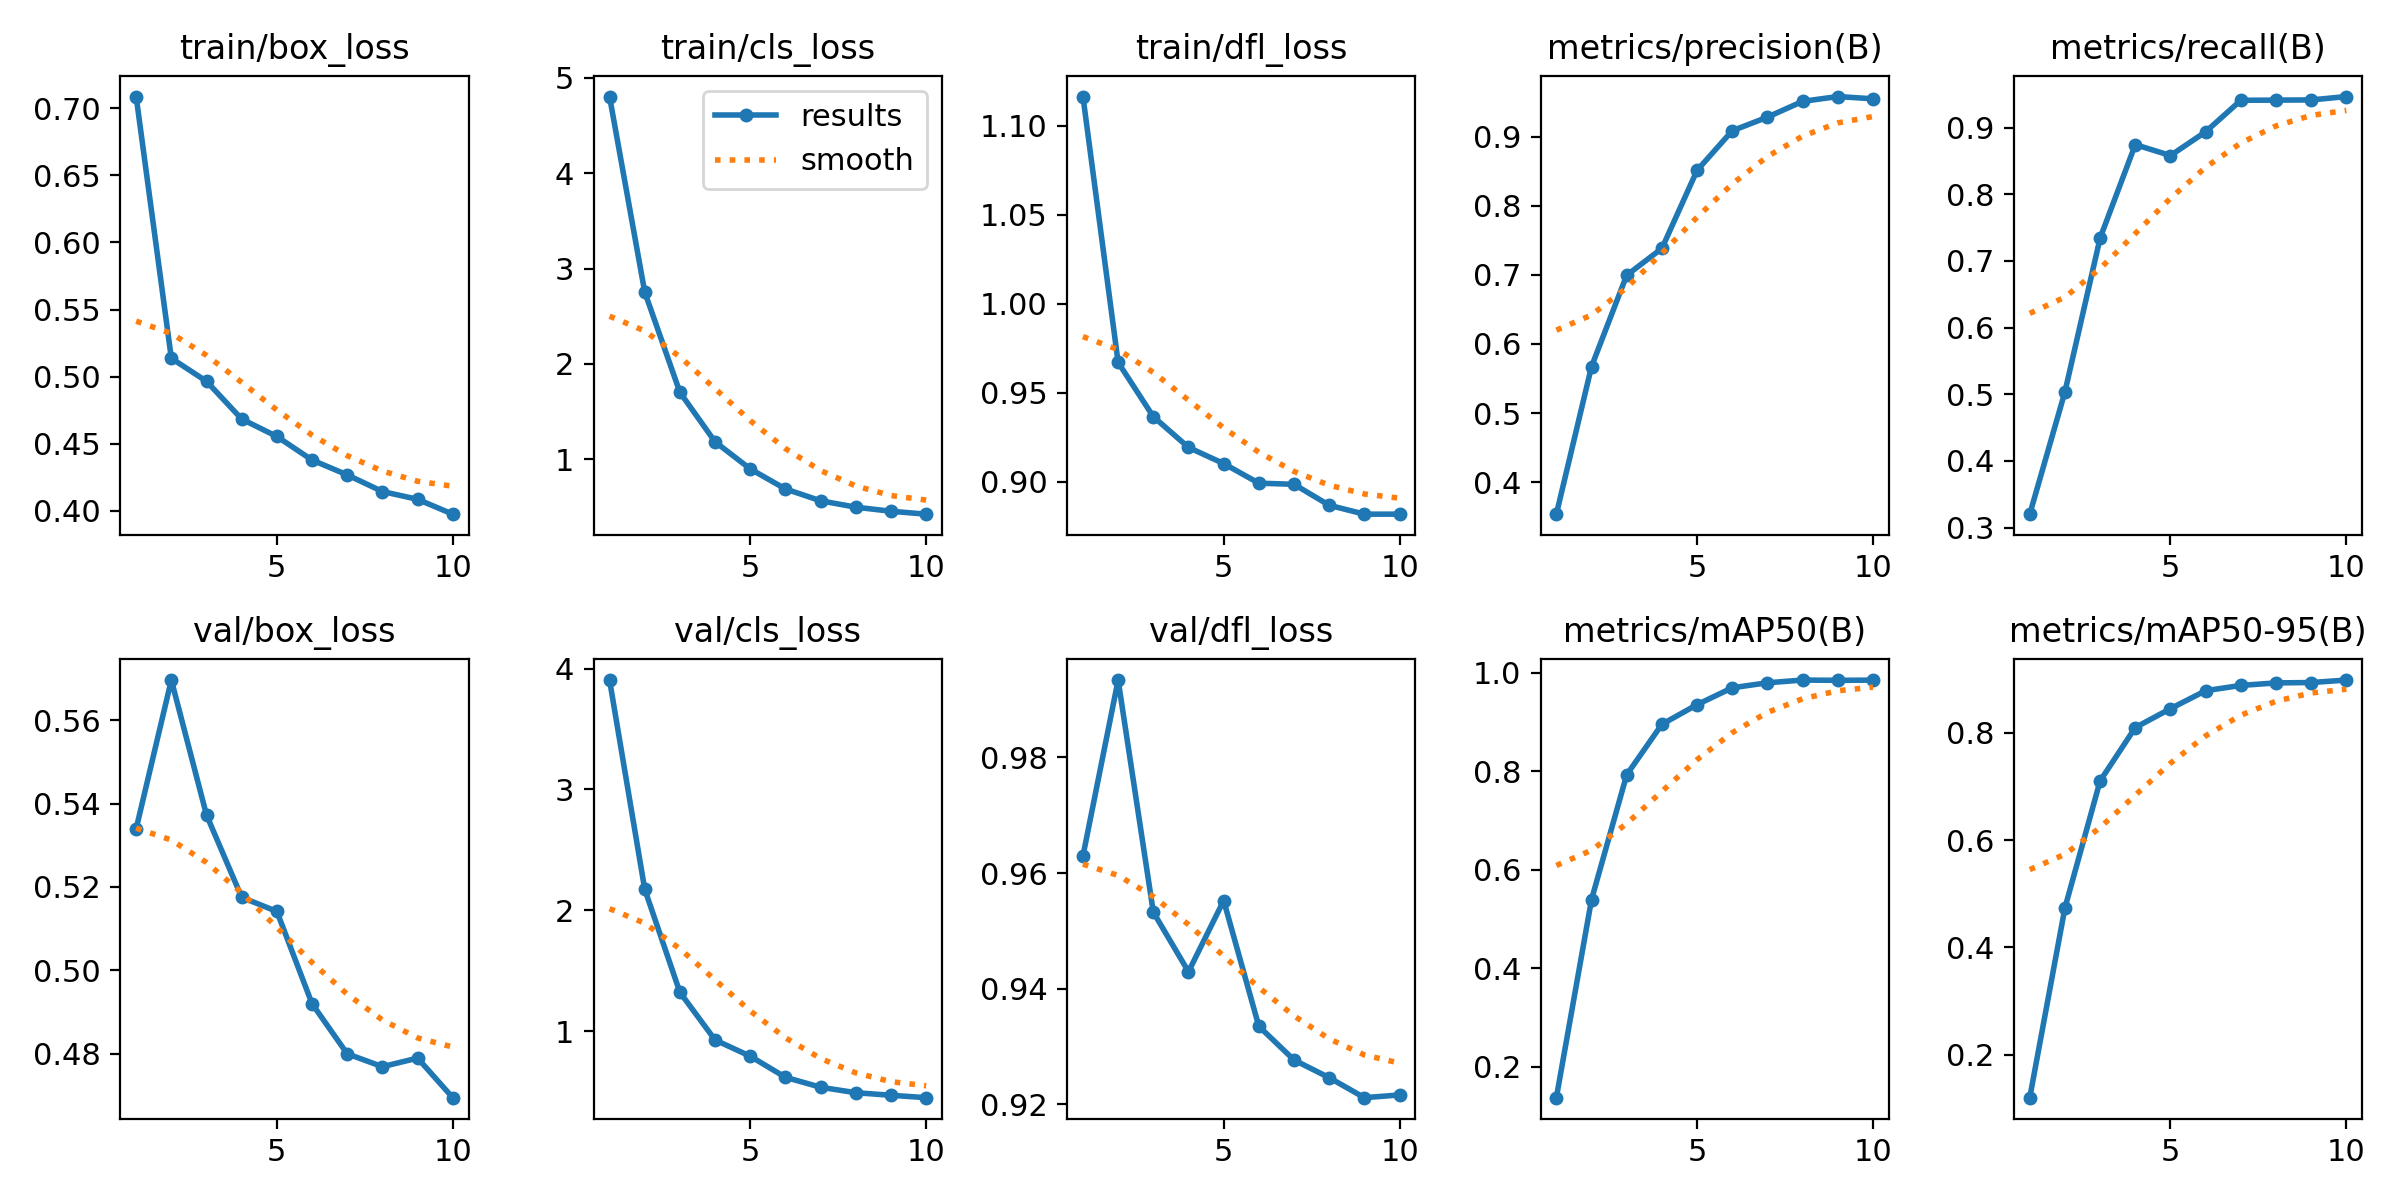

In [10]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

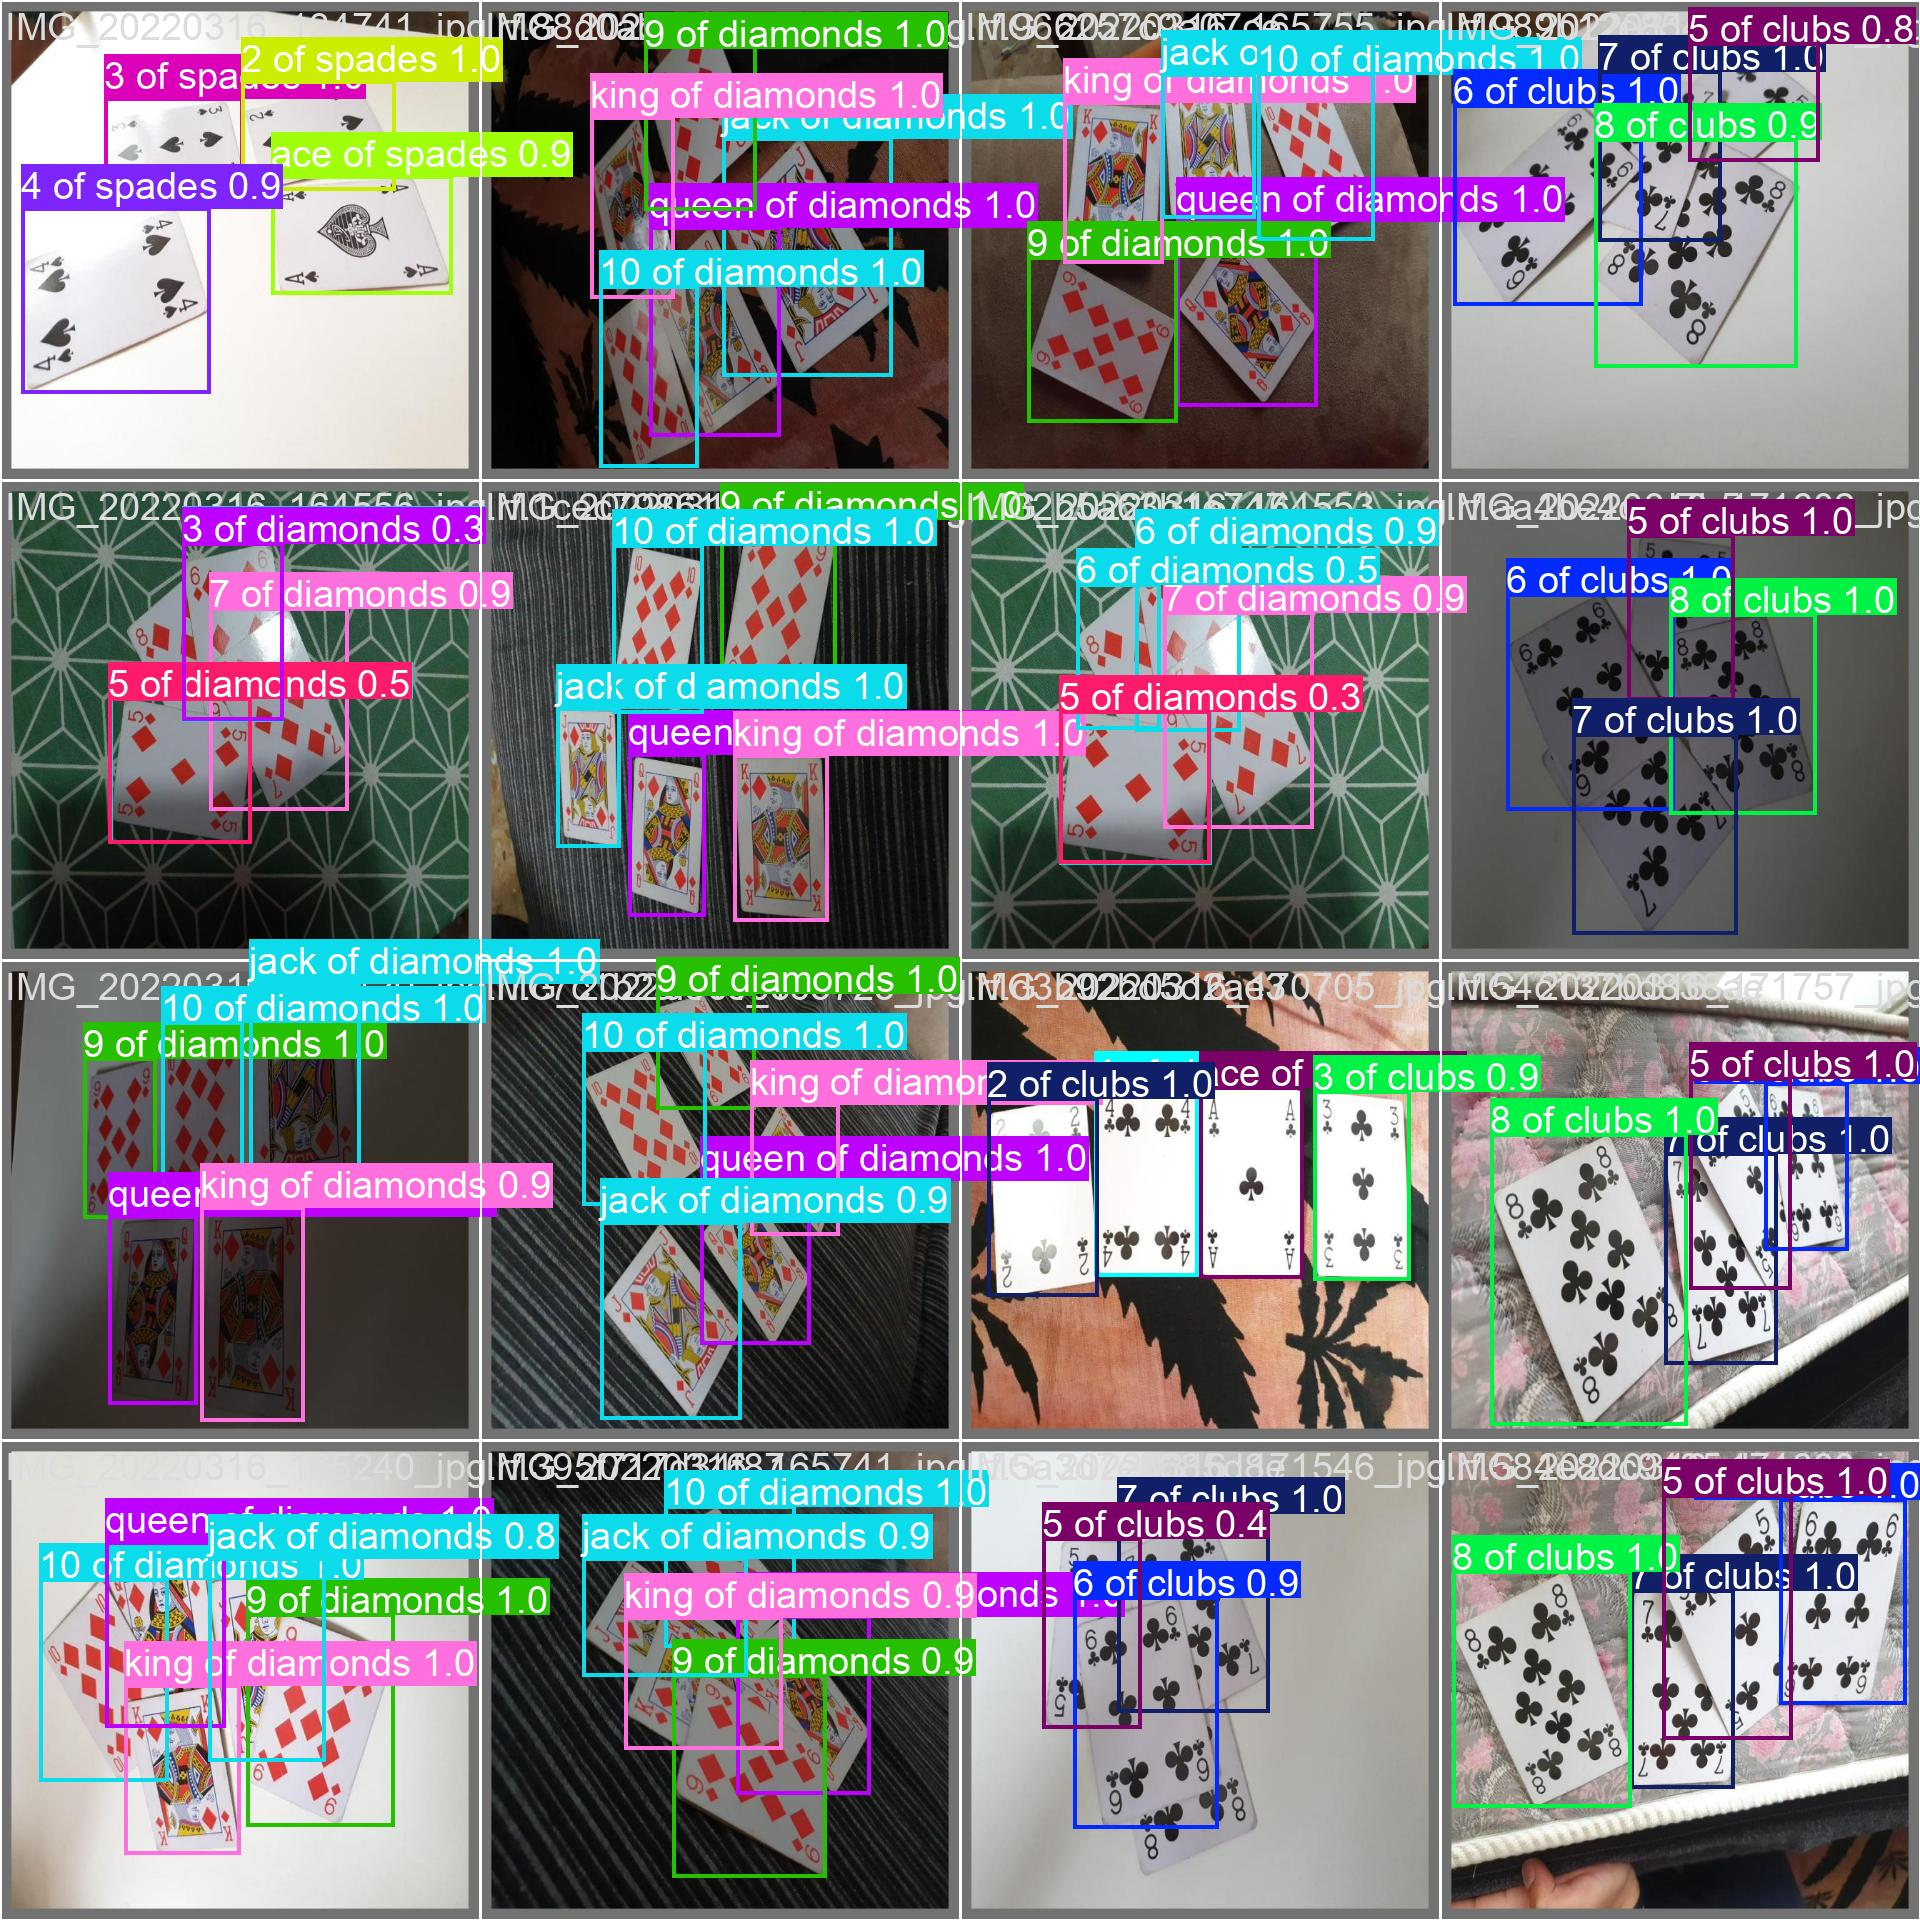

In [11]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [12]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.1 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,432,924 parameters, 0 gradients, 21.4 GFLOPs
val: Scanning /content/datasets/poker-cards-4/valid/labels.cache... 44 images, 0 backgrounds, 0 corrupt: 100% 44/44 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 3/3 [00:03<00:00,  1.13s/it]
                   all         44        197      0.955      0.946      0.985      0.898
           10 of clubs          3          3      0.963          1      0.995       0.94
        10 of diamonds          7          7      0.981          1      0.995      0.959
          10 of hearts          7          7      0.996          1      0.995      0.877
          10 of spades          4          4       0.99          1      0.995      0.692
            2 of clubs          2          2      0.936          1      0.995      0.995
         2 of diamonds          2          2

## Inference with custom model

In [13]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.1 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,432,924 parameters, 0 gradients, 21.4 GFLOPs

image 1/44 /content/datasets/poker-cards-4/test/images/IMG_20220316_134701_jpg.rf.27aa29de9d6012ae05c64b156f7c07b8.jpg: 640x640 1 2 of spades, 1 3 of spades, 1 4 of spades, 1 ace of spades, 15.8ms
image 2/44 /content/datasets/poker-cards-4/test/images/IMG_20220316_135012_jpg.rf.ee7179374d33235528db011cb5418226.jpg: 640x640 1 2 of spades, 1 3 of spades, 1 4 of spades, 1 ace of spades, 15.8ms
image 3/44 /content/datasets/poker-cards-4/test/images/IMG_20220316_135021_jpg.rf.d038afdef1a927103dae268ff392888f.jpg: 640x640 1 2 of spades, 1 3 of spades, 1 4 of spades, 1 ace of spades, 15.8ms
image 4/44 /content/datasets/poker-cards-4/test/images/IMG_20220316_140241_jpg.rf.c44522806b5455bfb03a638aa3ffa896.jpg: 640x640 2 5 of spadess, 1 6 of spades, 2 7 of spadess, 1 8 of spades, 15.7ms
image 5/44 /content/datasets/poker-cards-4/tes

**NOTE:** Let's take a look at few results.

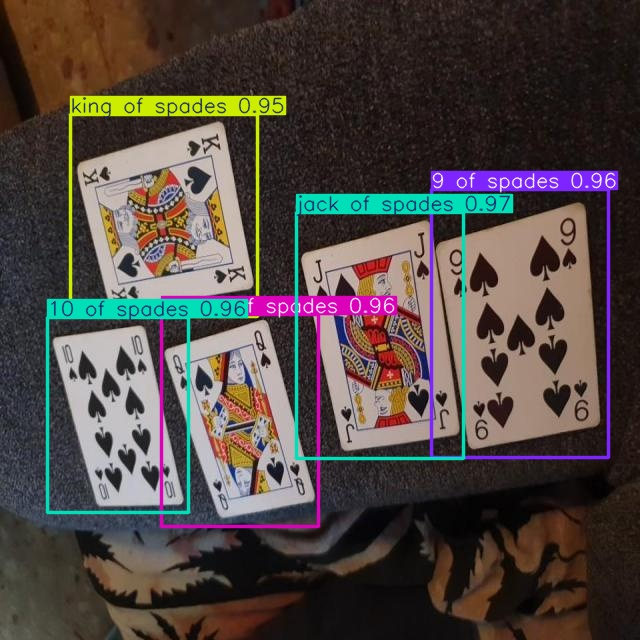

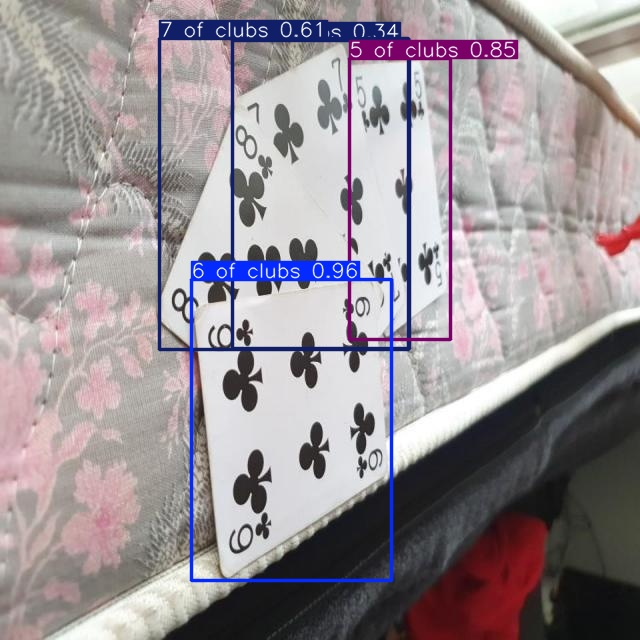

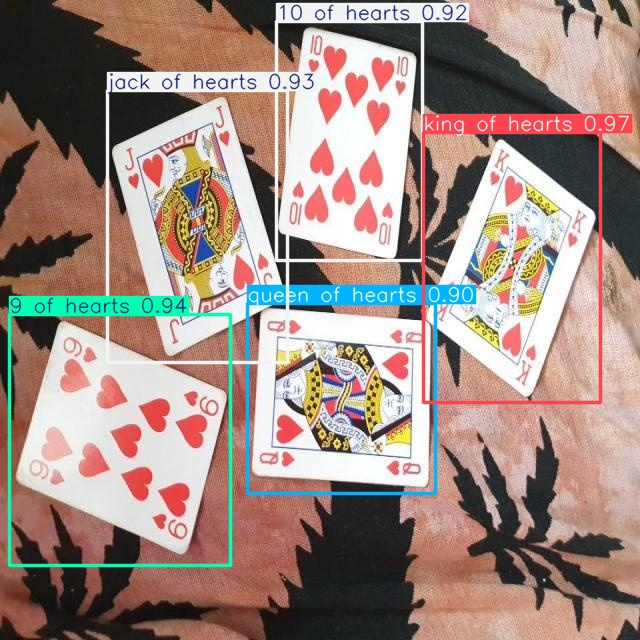

In [14]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")